# Orthogonal Dictionary Learning with Manifolds

This code implements Riemannian gradient descent to solve the dictionary learning problem:

$$\min_{\mathbf{A}, \mathbf{X}} \frac{1}{2} ||\mathbf{Y} - \mathbf{A}\mathbf{X}||_{F} + \mu ||\mathbf{X}||_1 \,\,\, \text{ so that }\, \mathbf{A} \in \mathcal{O}(n) $$

where $\mathcal{O}(n) = \{ \mathbf{Z} \in \mathbf{R}^{n\times n} : \mathbf{Z}^T\mathbf{Z} = \mathbf{I} \}$.

In [206]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
%matplotlib inline

from pdb import set_trace

## Helper Functions

In [160]:
def huber(x,mu):
    '''
    Input:
      x:   input argument to huber function 
           note- this can be vector/matrix, or any np array
      mu:  huber parameter
        
    Output: 
      out: huber function output  
    '''
    out = np.where(np.abs(x) >= mu, np.abs(x), 0.5 * mu + 0.5 * x**2 / mu)
    return np.sum(out)


def huber_grad(x,mu):
    '''
    Input: 
      x:   input argument to huber function 
           note- this can be vector/matrix,so make sure your implementation 
                 apply elementwise 
      mu:  huber parameter
        
    Output: 
      out: huber derivative output  
    '''
    out = np.where(np.abs(x) >= mu, np.sign(x), x / mu)
    return out

## Algorithms

In [194]:
# Backtrack line search for RGD 
def backtrack(z, f, grad, rt, eta, alp = 2, beta = 0.5):    
    '''
    Input: 
        z:     Current location
        f:     Objective function 
        grad:  Riemannian Gradient 
        rt:    Retraction Map
        alp:   Warm start parameter 
        beta:  Step size decay parameter 
        eta:   Step size from previous iteration

    Output: 
        eta: step size 
    '''    
    # Backtracking Line Search for Riemannian Gradient Descent 
    
    eta = alp
    while f(z) - f(rt(z, -eta * grad(z))) < 0.5 * eta * np.linalg.norm(grad(z))**2:
        eta *= beta

    return eta

In [199]:
#Riemannian Gradient Descent with backtrack line search:
def RGD(z, rgf, rt, fun=lambda z: 0, niter=1000,eps=1e-6):
    
    '''
    Input: 
        z:     Initailization
        rgf:   Riemanning gradient functio position->tangent vector 
        rt:    Retraction Map
        fun:   User defined function (e.g objective function)
        niter: Number of iterations 
        eps:   Termination Criteria 
        
    Itermediate:
        eta:  step size
        
    Output: 
        z: final solution 
        out: objective values per iterations 
    '''
    out = np.empty(niter+1)
    out[0] = fun(z)

    eta = 1 #Intialized Step size
    for itr in range(niter):
    ## Riemannian Gradient Descent with backtrack line search
        eta = backtrack(z, fun, rgf, rt, eta)
        z = rt(z, -eta * rgf(z))
        out[itr+1] = fun(z)
        
        if (abs(out[itr+1] - out[itr]) / abs(out[itr])) < eps:
            break   
        
    return z, out[:itr+1]

## Generating Data 

In [200]:
## Generating Data
## Note: We are only solving for one column of A in part c, 
##       while trying to solve full matrix A         
np.random.seed(0)

n = 20
p = 200

theta = 0.3 #Bernoulli parameters, control sparsity of X

A0 = ortho_group.rvs(n)
B0 = np.random.binomial(1, theta, (n,1))
G0 = np.random.randn(n,p) 
X0 = B0*G0

Y = A0@X0

## Minimizing the Huber Loss Function on a Sphere

This section is only solving for one column of the dictionary.

In [201]:
Niter = 1000
mu0 = 0.02 # Huber Parameter 
Obj = lambda z : huber(Y.T @ z , mu0) # Objective function
proj = lambda z, v : v - np.dot(z,z.T) @ v # projection onto Tangent Space
GF = lambda z : Y @ huber_grad(Y.T @ z, mu0) # Gradient of Objective function (without constraints)
RGF = lambda z : proj(z, GF(z)) # Riemannian Gradient Function
Rt = lambda z, v : (z + v) / np.linalg.norm(z + v) # Retraction Mapping

a,out = RGD(z=np.ones((n,1))/np.sqrt(n), rgf=RGF, rt=Rt, fun=Obj, niter=Niter)

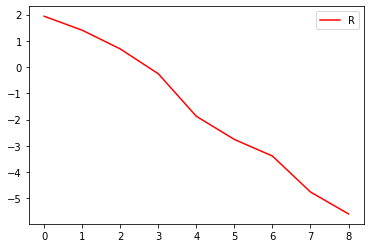

In [202]:
# Converence to the optimal value 
plt.plot(np.arange(len(out)-1),np.log10(np.array(out[:-1]-out[-1])),'r')

plt.legend((r'RGD'), loc = 'upper right')

## Solving for the Whole Dictionary

In [210]:
np.random.seed(1)

Niter = 1000
mu0 = 0.02 # Huber Parameter 
sym = lambda Z: (Z+Z.T)/2                       

Obj = lambda Z : huber(Y.T @ Z , mu0) # Objective function
proj = lambda Z, V : V - Z @ sym(Z.T @ V) # projection onto Tangent Space
GF = lambda Z : Y @ huber_grad(Y.T @ Z, mu0) # Gradient of Objective function (without constraints)
RGF = lambda Z : proj(Z, GF(Z)) # Riemannian Gradient Function
Rt = lambda Z, V : (Z + V) @ np.linalg.inv(sqrtm(np.identity(Z.shape[0]) + V.T @ V)) #TODO: Fill inRetraction Mapping

A,out = RGD(z=ortho_group.rvs(n), rgf=RGF, rt=Rt, fun=Obj, niter=Niter)

C:\Users\berpr\AppData\Local\Temp/ipykernel_13796/185231479.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  out[itr+1] = fun(z)


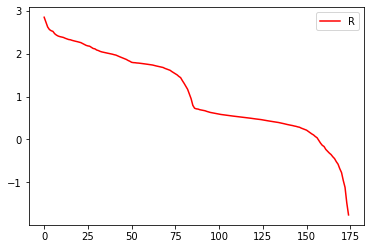

In [211]:
# Converence to the optimal value 
plt.plot(np.arange(len(out)-1),np.log10(np.array(out[:-1]-out[-1])),'r')

plt.legend((r'RGD'), loc = 'upper right')